# Modeling

In [14]:
# general Imports
import os
import pandas as pd
import numpy as np
import pickle
import sys
import tensorflow as tf
import sklearn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from PIL import Image
from collections import Counter

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

# Neural Network
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import concatenate, Input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import backend as K
from keras.callbacks import CSVLogger

# import helper functions
from model_helper import train_test_split_custom, weighted_bce, create_dataset_multi
from model_helper import accuracy_on_one, accuracy_on_zero
from model_helper import precision_on_1, print_layer_trainable

%matplotlib inline
plt.rcParams['figure.figsize'] = (16,8)

# Set Parameters and directories to save models

## Parameters

In [15]:
model_id = 'Multi_with_more_dropout'
number_of_images = 'all'
EPOCHS = 30
neurons_per_dense = 1024
dense_layers = 2
open_layers = 2
penalty_weight = 10
csv = '../1_cleaning/metadata_cleaned_all.csv'

# Preprocessing

In [16]:
# One hot encode all the categorical variables, and get the image paths
train_test = train_test_split_custom(number_of_images, csv, multiple_input=True)
X_train_images, X_val_images, X_train_hier, X_val_hier, y_train_bin, y_val_bin, features = train_test

In [17]:
# Create image pipeline and create dataset to feed model
dataset_multi_train = create_dataset_multi(X_train_images,X_train_hier, y_train_bin)
dataset_multi_val = create_dataset_multi(X_val_images,X_val_hier, y_val_bin)

## Directories

### File naming conventions
Files should be saved in the following convention, which is outlined in the readme file
model#_sample_size#_epoch#_dense#_trainable_layers_loss_function

In [18]:
# Create the name of the model
name_of_model = 'model_' + model_id + \
                '_sample_size_' + str(number_of_images) + \
                '_epoch_' + str(EPOCHS) + \
                '_dense_' + str(dense_layers) + \
                '_neurons_' + str(neurons_per_dense) + \
                '_losswbc_' + \
                '_num_open_layers_' + str(open_layers) + \
                '_penalty_weight_' + str(penalty_weight)

base_path = '/home/ubuntu/efs/models/'
    
checkpoint_path = base_path + 'Checkpoints/' + name_of_model + '.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

csv_logger = CSVLogger(base_path + 'Training_history/' + name_of_model + "_history_log.csv", append=True)
training_history_path = base_path + 'Training_history/' + name_of_model + '.pickle'

saved_model_path = base_path + 'Saved_models/' + name_of_model + '.h5'

model_image_path = base_path + 'Model_image/' + model_id + '.png'


# Model set-up

## Load the VGG19 pretrained network 

In [12]:
# Setup the multi-input model from https://www.programcreek.com/python/example/89660/keras.layers.concatenate
num_label = y_train_bin.shape[1]

def getMultiModel():
    
    base_model = VGG19(include_top=False, weights='imagenet', input_shape=(224,224,3))
    
    # Setup the trainability of the VGG
    base_model.trainable = False if open_layers < 1 else True
    
    for layer in base_model.layers[:-(open_layers+1):]:
        layer.trainable =  False
    
    x = base_model.get_layer('block5_pool').output
    

    x = Flatten()(x)
    
    x = Dense(neurons_per_dense, activation='relu', name='fc_1')(x)
    
    input_2 = Input(shape=X_train_hier.shape[1], name="hier")
    
    hier_layer = Dense(32, activation='relu', name = 'fc_hier')(input_2)
    
    merge_one = concatenate([x, hier_layer])
    merge_one = Dropout(0.3)(merge_one)
    
    merge_one = Dense(neurons_per_dense, activation='relu', name='fc_2')(merge_one)
    merge_one = Dropout(0.3)(merge_one)
    
    predictions = Dense(num_label, activation='sigmoid')(merge_one)
    
    # Define the models
    model = Model(inputs=[base_model.input, input_2], outputs=predictions)
    
    # Settings
    LR = 1e-5
    optimizer = Adam(lr=LR)
    loss = weighted_bce
    metrics = [accuracy_on_one, accuracy_on_zero, precision_on_1]
    
    model.compile(optimizer=optimizer, 
                  loss=loss, 
                  metrics=metrics)
    
    return model 


In [13]:
multi_input_model = getMultiModel()

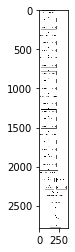

In [14]:
tf.keras.utils.plot_model(
    multi_input_model,
    # to_file=model_image_path,
    show_shapes=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96
)


In [15]:
# multi_input_model.summary()

In [16]:
print_layer_trainable(multi_input_model)

False:	input_2
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_conv4
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_conv4
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
True:	block5_conv3
True:	block5_conv4
True:	block5_pool
True:	flatten_1
True:	hier
True:	fc_1
True:	fc_hier
True:	concatenate_1
True:	dropout_2
True:	fc_2
True:	dropout_3
True:	dense_1


In [17]:
multi_input_model.trainable

True

## Create a callback checkpoint 

In [18]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
history = multi_input_model.fit(dataset_multi_train,
                    epochs=EPOCHS,
                    validation_data=dataset_multi_val,
                    callbacks=[cp_callback,
                               csv_logger,
                               #sanity_check_callback,
                              ])

Epoch 1/30
    417/Unknown - 157s 375ms/step - loss: 0.8061 - accuracy_on_one: 0.8030 - accuracy_on_zero: 0.7702 - precision_on_1: 0.2379
Epoch 00001: saving model to /home/ubuntu/efs/models/Checkpoints/model_Multi_with_more_dropout_sample_size_all_epoch_30_dense_2_neurons_1024_losswbc__num_open_layers_2_penalty_weight_10.ckpt
417/417 [==============================] - 197s 472ms/step - loss: 0.8061 - accuracy_on_one: 0.8030 - accuracy_on_zero: 0.7702 - precision_on_1: 0.2379 - val_loss: 0.0000e+00 - val_accuracy_on_one: 0.0000e+00 - val_accuracy_on_zero: 0.0000e+00 - val_precision_on_1: 0.0000e+00
Epoch 2/30
416/417 [============================>.] - ETA: 0s - loss: 0.6028 - accuracy_on_one: 0.8619 - accuracy_on_zero: 0.8507 - precision_on_1: 0.3263
Epoch 00002: saving model to /home/ubuntu/efs/models/Checkpoints/model_Multi_with_more_dropout_sample_size_all_epoch_30_dense_2_neurons_1024_losswbc__num_open_layers_2_penalty_weight_10.ckpt
417/417 [==============================] - 187s 

## Load old weights?

In [ ]:
# Loads the weights from the checkpoint path above
# new_model.load_weights(checkpoint_path)

## Create the datasets (incl. image pre-processing, resizing, putting into batches)

## Save history and model

In [ ]:
# Save the training history
pickle.dump(history.history, open(training_history_path, 'wb'))

# Save the model
multi_input_model.save(saved_model_path)

In [19]:
saved_model_path

'/home/ubuntu/efs/models/Saved_models/model_Multi_input_sample_size_15000_epoch_10_dense_2_neurons_1024_losswbc__num_open_layers_2_penalty_weight_10.h5'